In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy
from statsmodels.tsa.stattools import adfuller

from datetime import datetime
from data_retriever import DataRetriever
from differentiation import FractionalDifferentiation
from visualisation import plot_two_series

/home/marcin/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Config
PATH_TO_DB = './data.db'

In [3]:
# Data 
dr = DataRetriever(
    db=PATH_TO_DB,
    start_dt=datetime.fromisoformat('2021-01-01'),
    end_dt=datetime.fromisoformat('2023-06-29')
)
data = dr.retrieve()
data

,ticker,per,date,time,open,high,low,close,vol,openint,dt
0,ETH.V,D,20210101,000000,741.600,749.700,717.480,730.810,0.000000e+00,0.0,2021-01-01
1,ETH.V,D,20210102,000000,730.860,788.270,716.780,772.680,0.000000e+00,0.0,2021-01-02
2,ETH.V,D,20210103,000000,772.700,996.630,765.650,993.130,0.000000e+00,0.0,2021-01-03
3,ETH.V,D,20210104,000000,992.820,1163.360,894.100,1014.430,0.000000e+00,0.0,2021-01-04
4,ETH.V,D,20210105,000000,1012.800,1132.900,975.770,1112.740,0.000000e+00,0.0,2021-01-05
...,...,...,...,...,...,...,...,...,...,...,...
905,ETH.V,D,20230625,000000,1876.361,1930.389,1870.177,1896.207,2.719188e+06,0.0,2023-06-25
906,ETH.V,D,20230626,000000,1895.826,1908.688,1837.627,1851.199,2.879392e+06,0.0,2023-06-26
907,ETH.V,D,20230627,000000,1851.009,1912.616,1847.566,1896.071,2.691181e+06,0.0,2023-06-27
908,ETH.V,D,20230628,000000,1896.071,1896.730,1825.090,1829.822,2.736574e+06,0.0,2023-06-28


In [4]:
y = data['close'].values
space = np.linspace(0, 1, 20)
results = []
for d in space:
    fd = FractionalDifferentiation(d=d)
    fd.fit(y)
    y_diff = fd.transform(y)
    adf_result = adfuller(y_diff[~np.isnan(y_diff)])
    pearson_result = scipy.stats.pearsonr(y[1:], y_diff[1:])
    record = {
        'd': d,
        'adf_statistic': adf_result[0],
        'critial_value_5%': adf_result[4]['5%'],
        'pearson_coef': pearson_result[0],
        'pearson_pvalue': pearson_result[1]
    }
    results.append(record)
results_df = pd.DataFrame(results)
results_df

,d,adf_statistic,critial_value_5%,pearson_coef,pearson_pvalue
0,0.000000,-2.065164,-2.864750,1.000000,0.000000e+00
1,0.052632,-2.152422,-2.864750,0.988477,0.000000e+00
2,0.105263,-2.317153,-2.864750,0.958108,0.000000e+00
3,0.157895,-2.551094,-2.864750,0.914058,0.000000e+00
4,0.210526,-2.846783,-2.864750,0.859857,4.656422e-267
5,0.263158,-3.198464,-2.864750,0.797725,1.915745e-201
6,0.315789,-3.601778,-2.864750,0.729121,1.503304e-151
7,0.368421,-4.052909,-2.864750,0.655289,1.261973e-112
8,0.421053,-4.547608,-2.864750,0.577727,4.724433e-82
9,0.473684,-5.046923,-2.864746,0.498478,2.903669e-58


In [5]:
# Quasi-optimal d
optimal_d = results_df.loc[results_df['adf_statistic']<results_df['critial_value_5%'], 'd'].values[0]
optimal_d

0.2631578947368421

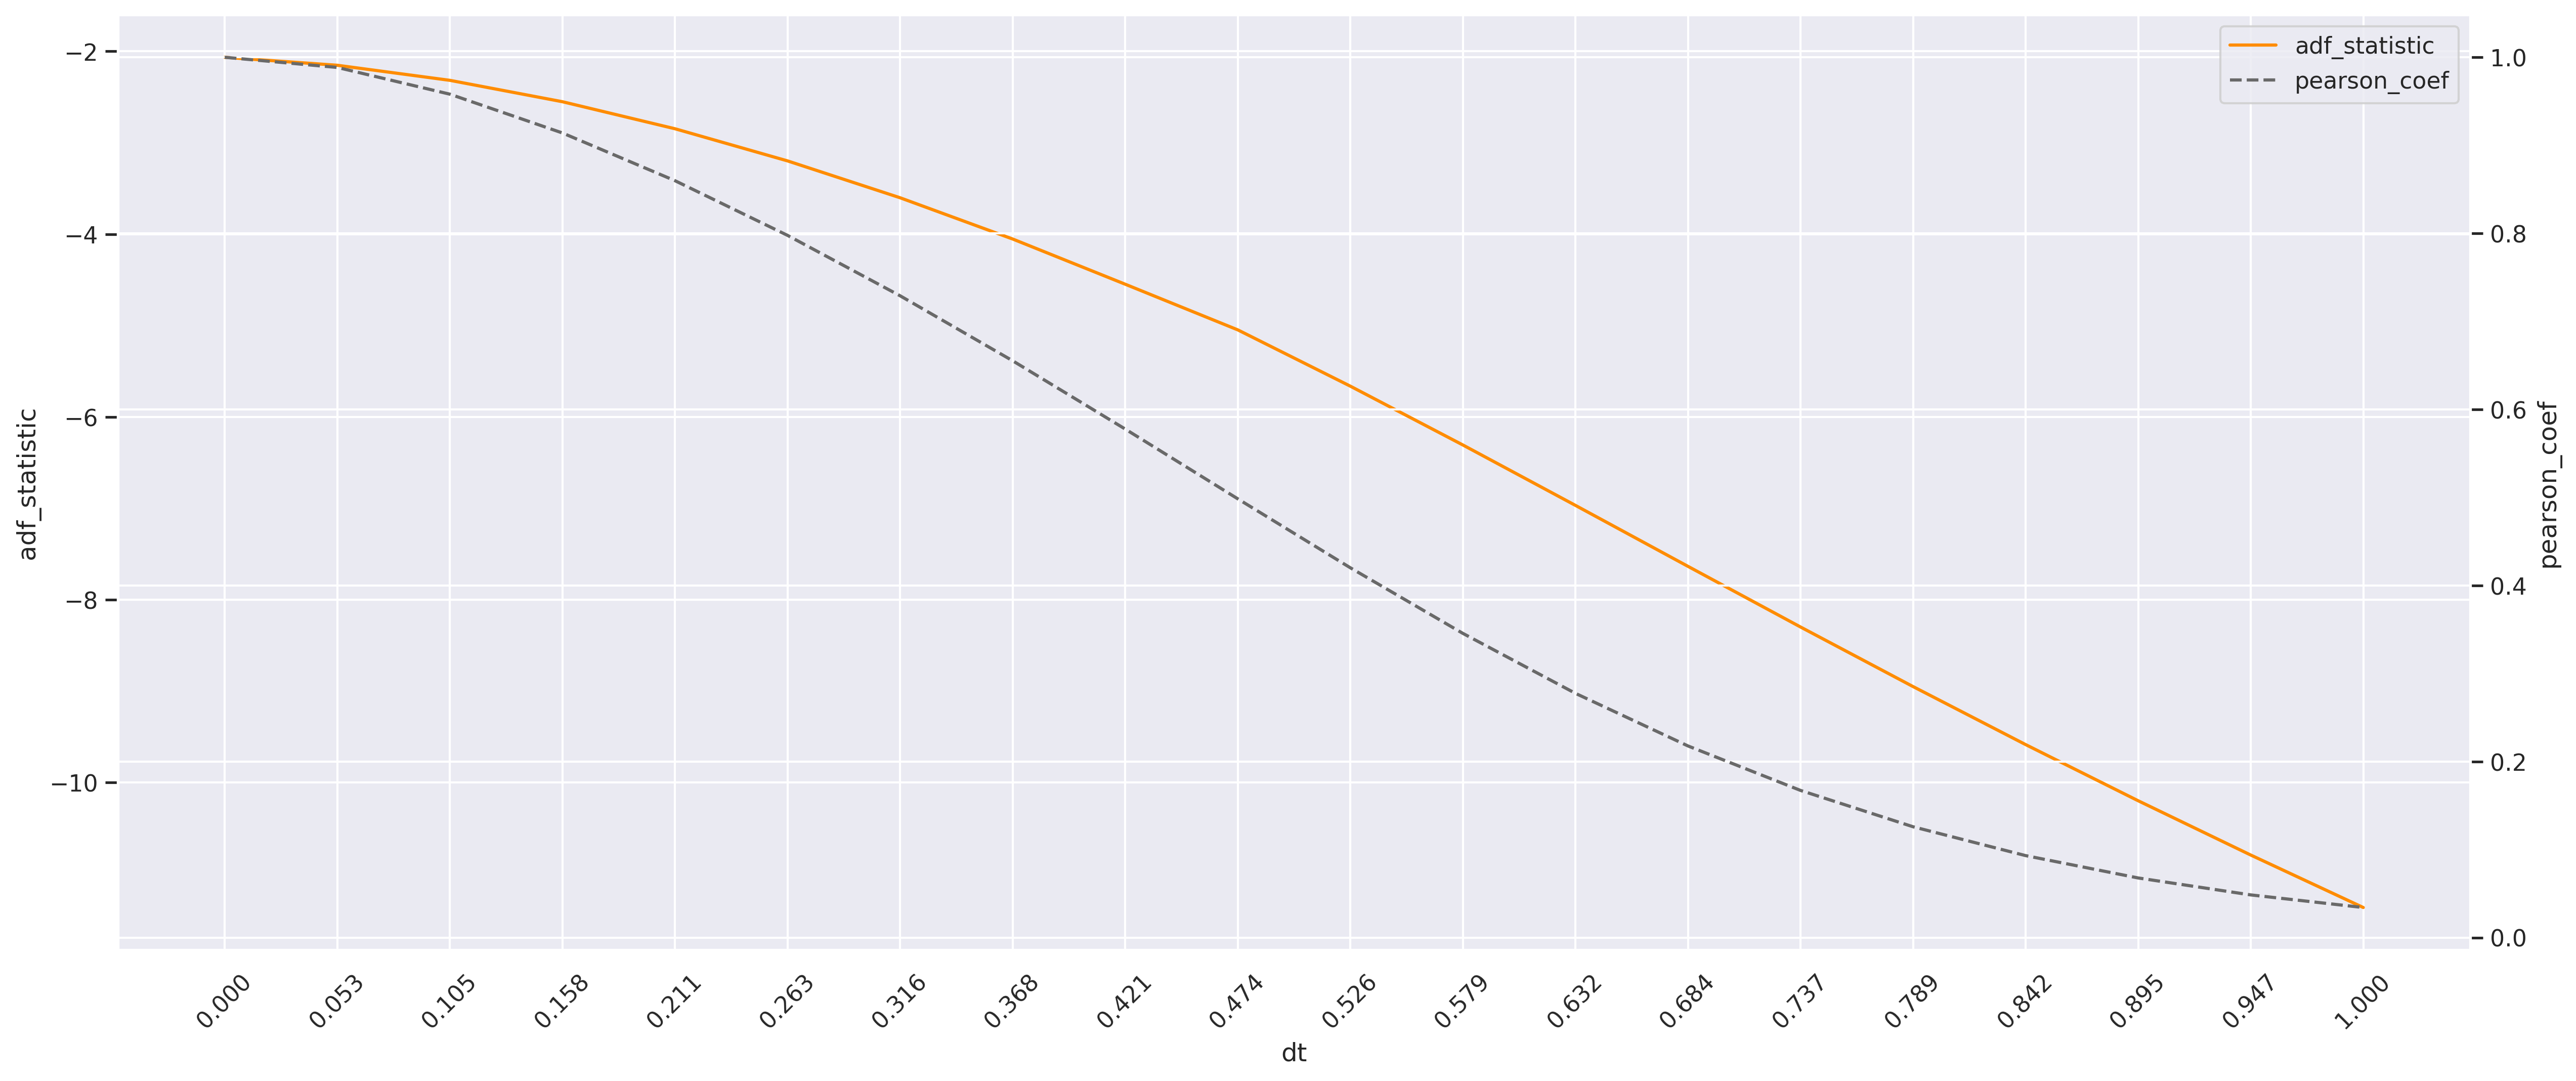

In [6]:
# Plot ADF statistc versus Pearson's correlation coefficient 
plot_two_series(
    x=results_df['d'].values,
    y1=results_df['adf_statistic'].values,
    y2=results_df['pearson_coef'].values,
    y1_label='adf_statistic',
    y2_label='pearson_coef'
)

In [7]:
# Check if differenced y_t with quasi-optimal d is stationary
fd = FractionalDifferentiation(d=optimal_d)
fd.fit(y)
y_diff = fd.transform(y)
result = adfuller(y_diff[~np.isnan(y_diff)])
print("H0: unit root")
print(f"ADF Statistic: {result[0]}")
print(f"Critical value 5%: {result[4]['5%']}")
print(f"p-value: {result[1]}")

H0: unit root
ADF Statistic: -3.1984643980362675
Critical value 5%: -2.8647495822909477
p-value: 0.020073738132988614


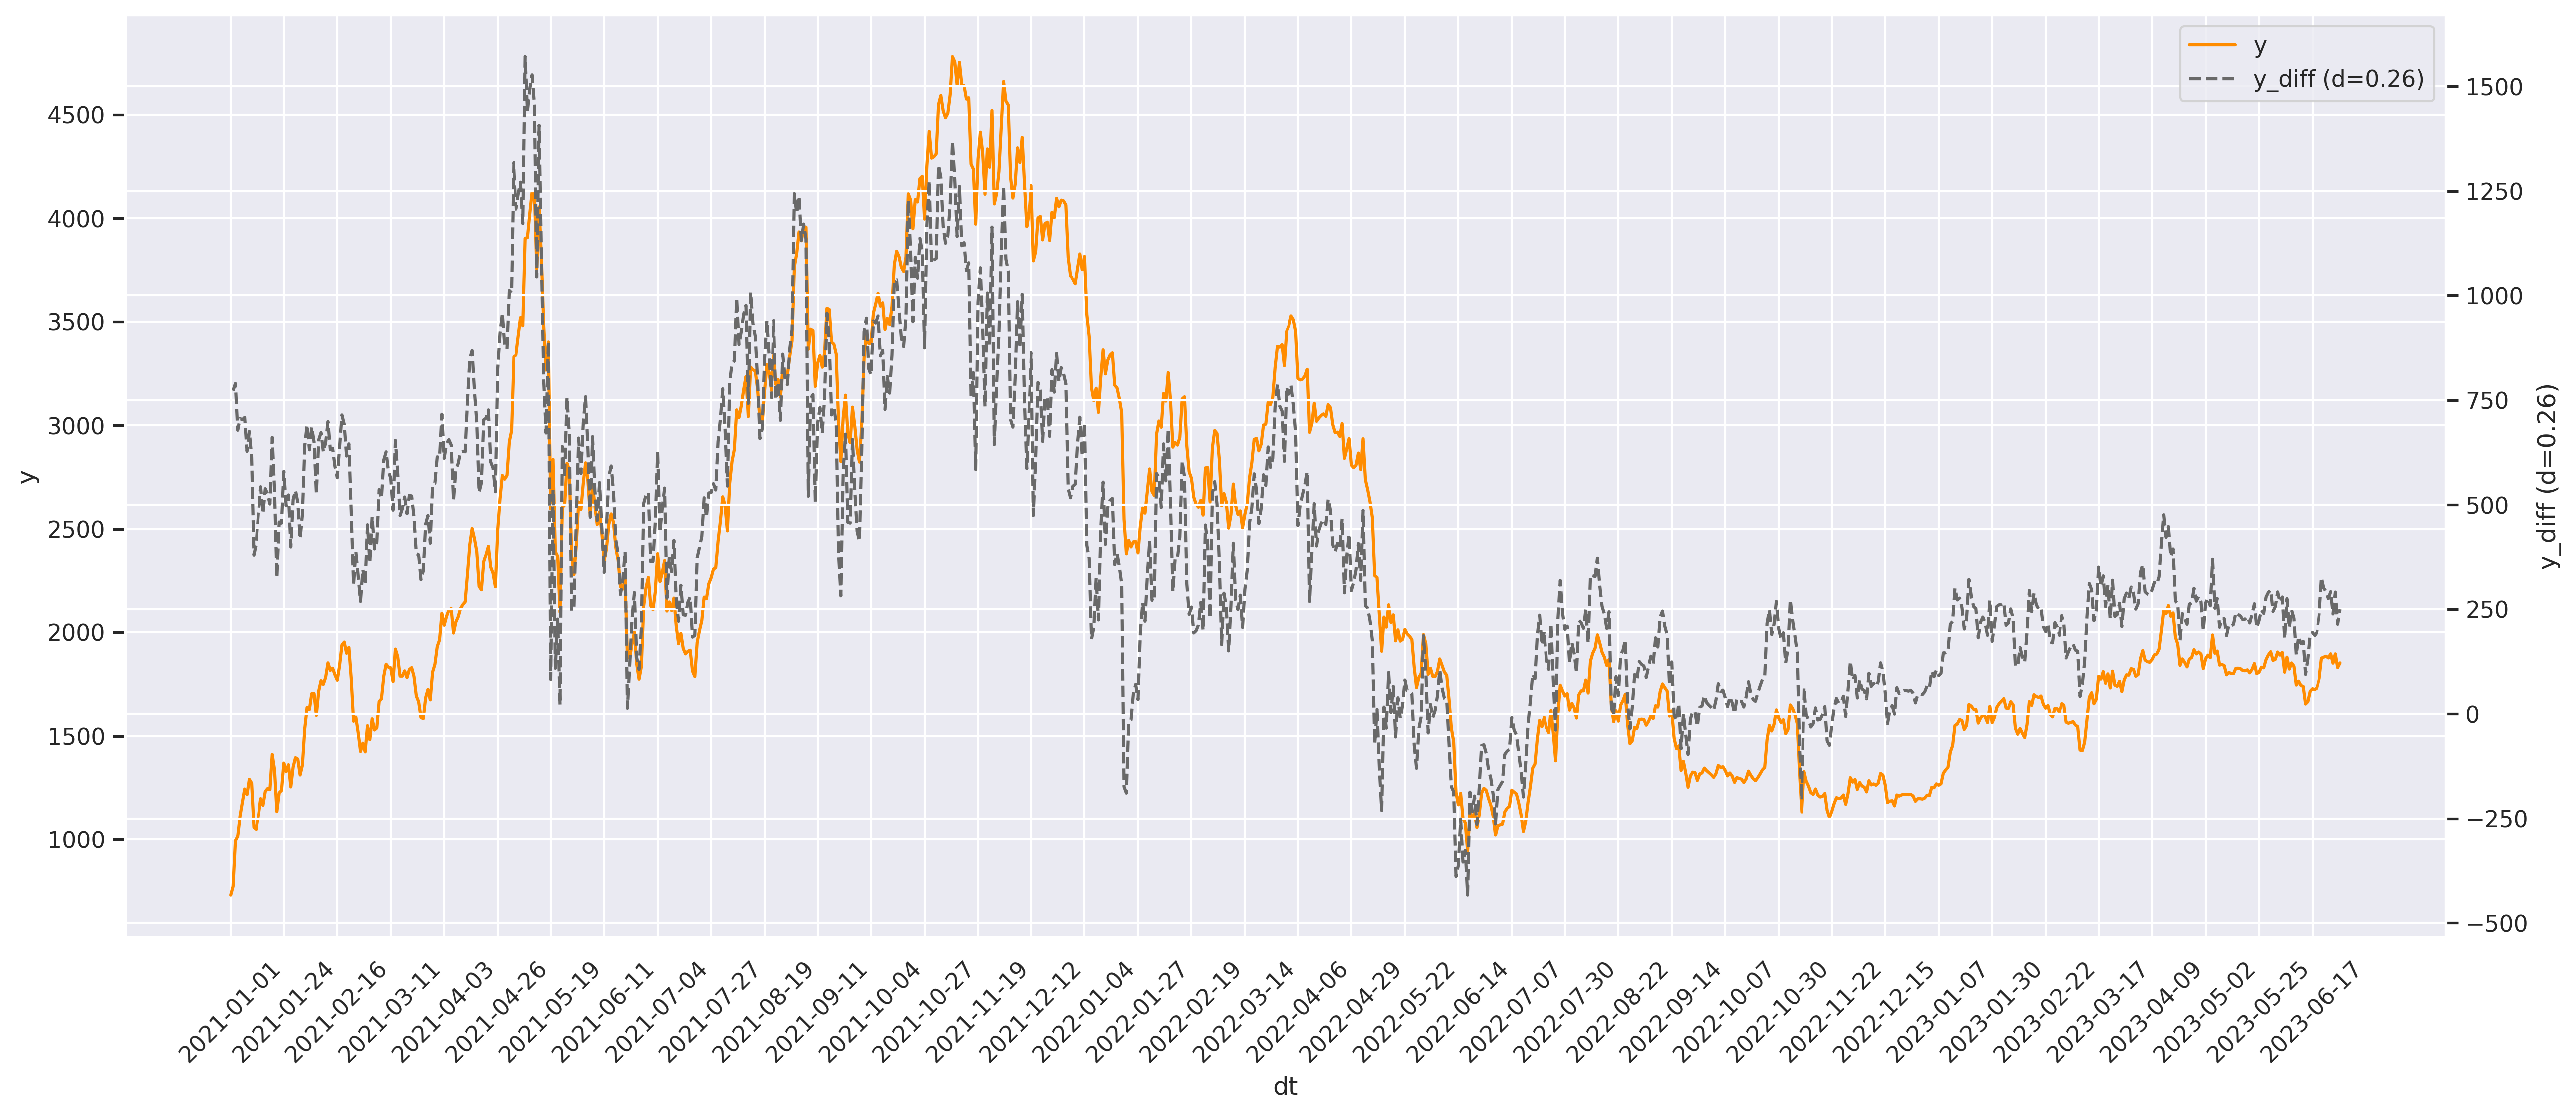

In [8]:
# Plot y_t vs differenced y_t
plot_two_series(
    x=data['dt'], 
    y1=y, 
    y2=y_diff, 
    y1_label='y', 
    y2_label=f"y_diff (d={round(optimal_d,2)})"
)